In [1]:
import pandas as pd
import numpy as np
import math
import operator
import os
import seaborn as sns

In [2]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import load_digits
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
from keybert import KeyBERT
from keybert._mmr import mmr
from keybert._maxsum import max_sum_distance
from keybert._highlight import highlight_document
from keybert.backend._utils import select_backend
from tqdm import tqdm
from typing import List, Union, Tuple
from matplotlib import pyplot as plt
from scipy import linalg
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist

/home/slava/UNSW/translationanalysis-Georgianlanguage/.venv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
2024-07-22 20:35:29.790156: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-22 20:35:30.071298: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 20:35:30.184552: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin 

In [3]:
model = SentenceTransformer('all-mpnet-base-v2')

In [4]:
pd.options.display.max_colwidth = 250
texts_path = '../Georgian Texts/Vazha Pshavela/'
poems_path = texts_path + 'Poems/revised/'

In [5]:
poem_names = []
sources = ['ge/', 'en/', 'ggl/', 'gem/', 'gem_ru/', 'gpt/', 'gpt_ru/']
ge_poems_directory = os.fsencode(poems_path + 'ge/')
for file in sorted(os.listdir(ge_poems_directory)):
    poem_names.append(file.decode())

In [7]:
print('Number of verses')
print('==============================================================================================')
print('ID\tVazha\tHewitt\tGoogle\tGemini\tGem_ru\tChatGPT\tGPT_ru\tPassed?\tPoem Name')
for poem in poem_names:
    output = [poem[:2]]
    for source in sources:
        with open(poems_path + source + poem, "r") as file:
            output.append(str(sum(1 for _ in file)))
    if len(set(output[1:])) > 1:
        output.append('No')
    else:
        output.append('Yes')
    output.append(poem[3:-3].replace('_', ' ').title())
    print('\t'.join(output))

Number of verses
ID	Vazha	Hewitt	Google	Gemini	Gem_ru	ChatGPT	GPT_ru	Passed?	Poem Name
01	4	4	4	4	4	4	4	Yes	I Believe I Always Have Believed
02	36	36	36	36	36	36	36	Yes	Bakur
03	9	9	9	9	9	9	9	Yes	Some Day It Will Happen I Shall Die
04	14	14	14	14	14	14	14	Yes	I Feel Like Singing And I Shall Sing
05	18	18	18	18	18	18	18	Yes	Voice From The Grave
06	10	10	10	10	10	10	10	Yes	That In Truth Is Not Manliness
07	17	17	17	17	17	17	17	Yes	The Law Of The World Is Thus
08	32	32	32	32	32	32	32	Yes	Amiran
09	29	29	29	29	29	29	29	Yes	The Old Song Of Cavaliers
10	17	17	17	17	17	17	17	Yes	Consciences Song
11	12	12	12	12	12	12	12	Yes	As Once You Did O Lady As Once You Did
12	17	17	17	17	17	17	17	Yes	Loneliness
13	15	15	15	15	15	15	15	Yes	What Created Me A Human Being
14	27	27	27	27	27	27	27	Yes	Yet Again Shall I See The Spring
15	34	34	34	34	34	34	34	Yes	Thrush Its The Same Song You Sing


In [8]:
verses = []
poem_verse_counts = []
df = pd.DataFrame(
    columns=[
        'Poem ID',
        'Poem Name',
        'Verse',
        'Vazha',
        'Hewitt',
        'Google',
        'Gemini',
        'Gemini_ru',
        'ChatGPT',
        'ChatGPT_ru',
        'Hewitt - Google',
        'Hewitt - Gemini',
        'Hewitt - Gemini_ru',
        'Hewitt - ChatGPT',
        'Hewitt - ChatGPT_ru'
    ]
)

for poem in poem_names:
    poem_id = int(poem[:2])
    poem_name = poem[3:-3].replace('_', ' ').title()

    poem_vazha = [line.strip() for line in open(poems_path + 'ge/' + poem, "r")]
    poem_hewitt = [line.strip() for line in open(poems_path + 'en/' + poem, "r")]
    poem_google = [line.strip() for line in open(poems_path + 'ggl/' + poem, "r")]
    poem_gemini = [line.strip() for line in open(poems_path + 'gem/' + poem, "r")]
    poem_gemini_ru = [line.strip() for line in open(poems_path + 'gem_ru/' + poem, "r")]
    poem_chatgpt = [line.strip() for line in open(poems_path + 'gpt/' + poem, "r")]
    poem_chatgpt_ru = [line.strip() for line in open(poems_path + 'gpt_ru/' + poem, "r")]

    verses.extend(poem_hewitt)
    verses.extend(poem_google)
    verses.extend(poem_gemini)
    verses.extend(poem_gemini_ru)
    verses.extend(poem_chatgpt)
    verses.extend(poem_chatgpt_ru)

    poem_verse_counts.append(len(poem_vazha))
    for i in range(len(poem_vazha)):
        row = {
            'Poem ID': [poem_id],
            'Poem Name': [poem_name],
            'Verse': [i + 1],
            'Vazha': [poem_vazha[i]],
            'Hewitt': [poem_hewitt[i]],
            'Google': [poem_google[i]],
            'Gemini': [poem_gemini[i]],
            'Gemini_ru': [poem_gemini_ru[i]],
            'ChatGPT': [poem_chatgpt[i]],
            'ChatGPT_ru': [poem_chatgpt_ru[i]]
        }
        df_new = pd.DataFrame(row)
        df = pd.concat([df, df_new], ignore_index = True)

df.shape

(291, 15)

In [9]:
df.to_csv('results/all_texts.csv')

In [11]:
verse_embeddings = model.encode(verses)
verse_embeddings.shape

(1746, 768)

In [12]:
for i, row in df.iterrows():
    poem_id = row['Poem ID']
    verse = row['Verse']
    offset = sum(poem_verse_counts[:poem_id-1]) * 6
    j = offset + verse - 1

    hewitt_google = cosine_similarity(
        [verse_embeddings[j]],
        [verse_embeddings[j + 1 * poem_verse_counts[poem_id - 1]]]
    )[0][0]
    
    hewitt_gemini = cosine_similarity(
        [verse_embeddings[j]],
        [verse_embeddings[j + 2 * poem_verse_counts[poem_id - 1]]]
    )[0][0]

    hewitt_gemini_ru = cosine_similarity(
        [verse_embeddings[j]],
        [verse_embeddings[j + 3 * poem_verse_counts[poem_id - 1]]]
    )[0][0]

    hewitt_chatgpt = cosine_similarity(
        [verse_embeddings[j]],
        [verse_embeddings[j + 4 * poem_verse_counts[poem_id - 1]]]
    )[0][0]

    hewitt_chatgpt_ru = cosine_similarity(
        [verse_embeddings[j]],
        [verse_embeddings[j + 5 * poem_verse_counts[poem_id - 1]]]
    )[0][0]    

    df.at[i,'Hewitt - Google'] = hewitt_google
    df.at[i,'Hewitt - Gemini'] = hewitt_gemini
    df.at[i,'Hewitt - Gemini_ru'] = hewitt_gemini_ru
    df.at[i,'Hewitt - ChatGPT'] = hewitt_chatgpt
    df.at[i,'Hewitt - ChatGPT_ru'] = hewitt_chatgpt_ru

In [11]:
df.head()

,Poem ID,Poem Name,Verse,Vazha,Hewitt,Google,Gemini,ChatGPT,Hewitt - Google,Hewitt - Gemini,Hewitt - ChatGPT
0,1,I Believe I Always Have Believed,1,"მრწამს, მარად მიწამებია მუდმივ სიცოცხლე სულისა, კარგისა, ქვეყნის მოყვარის, ქვეყნის ბედისგან წყლულისა.","I believe, I always have believed In the eternal life of the soul, The good, the lover of the world, Scarred by the fate of this same world.","I believe, there are always lands eternal life of the soul, Good, country lover, Ulcer from the fate of the country.","I believe, I've always believed In the eternal life of the soul, Of the good, the lover of the country, The one pained by the country's fate.","I believe, I have always believed in the eternal life of the soul, of the good, the lover of the homeland, the one suffering from the fate of the country.",0.534823,0.741352,0.767628
1,1,I Believe I Always Have Believed,2,"მრწამს, ფერფლნი კარგის გულისა ქარმ რო გაფანტოს ხმელადა, თვითოში მაინც ენთება ტიალ-სურვილი ცხელადა, –","I believe that, though the ashes of kind hearts Be scattered over the land by the wind, Yet in each of us there will burn Hotly a wish forlorn —","I believe that ashes are the heart of a good person Let the wind scatter the land, It still burns in itself Tial-desire was hot, –","I believe, even when the ashes Of a good heart are scattered by the wind, Within each one, a spark still ignites, A burning desire for warmth.","I believe, that even if the ashes of a good heart are scattered by the wind, they will still ignite a burning desire within, —",0.731435,0.758544,0.825589
2,1,I Believe I Always Have Believed,3,"ავის მჩაგრავად, კეთილის მუდამ იქნება მცველადა; ბეჩავის, გაჭირებულის მომხმარედ, მეშვლად, მხსნელადა.","To repress evil, and that this Will ever be a defence of the good, Help, succour and saviour Of the downtrodden and needy.","Evil oppressor, good There will always be a guard; Bechav, needy He helped me, helped me, saved me.","To suppress evil, to protect the good, It will always be a guardian; For the poor, the troubled, A helper, a savior, a rescuer.","as the protector against evil, the good will always be a guardian; for the helpless, the downtrodden a helper, a supporter, a savior.",0.419882,0.725808,0.590861
3,1,I Believe I Always Have Believed,4,"კარგს გულს არა ჰკლავს ბუნება, თან დააქვს ძველის-ძველადა!","Nature does not totally extinguish a kind heart, She carries it along with her from the very dawn of time.",Nature does not kill a good heart Brings old things with him!,"Nature does not kill a good heart, It carries it along, from time immemorial!","Nature does not kill a good heart, it carries the wisdom of the ancients!",0.661742,0.806899,0.761201
4,2,Bakur,1,"– გვიამბე, ელიზბარაო, რა ამბავ მოხდა ეღოსა?","Tell us, Elizbar, In Egho what did occur.","– Tell us, Elizabeth What happened to Egosa?","– Tell us, Elizbara, What happened at dawn?","Tell us, Elizbar, what happened at Egho?",0.457603,0.68623,0.907964


In [13]:
df.to_csv('results/cosine_similarity.csv')

In [13]:

# maximum_difference_easwaran_gandhi.to_csv('/content/drive/MyDrive/religious_texts/semantic analysis/all-mpnet-base-v2/easwaran gandhi.csv')
# maximum_difference_gandhi_purohit.to_csv('/content/drive/MyDrive/religious_texts/semantic analysis/all-mpnet-base-v2/gandhi purohit.csv')
# maximum_difference_purohit_easwaran.to_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/SM_RESULTS/purohit_google.csv')
# df.to_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/SM_RESULTS/cosine similarity - sklearn.csv')
# df_max_sum_cs.to_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/SM_RESULTS/max_sum_in_every_chapter.csv')
# df_min_sum_cs.to_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/SM_RESULTS/least_sum_in_every_chapter.csv')
# df = pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/SM_RESULTS/cosine_similarity.csv')

In [14]:
maximum_difference_hewitt_google = df.loc[(df['Hewitt - Google'] < 0.5)]
maximum_difference_hewitt_google.shape

(87, 15)

In [15]:
maximum_difference_hewitt_gemini = df.loc[(df['Hewitt - Gemini'] < 0.5)]
maximum_difference_hewitt_gemini.shape

(22, 15)

In [16]:
maximum_difference_hewitt_gemini_ru = df.loc[(df['Hewitt - Gemini_ru'] < 0.5)]
maximum_difference_hewitt_gemini_ru.shape

(34, 15)

In [17]:
maximum_difference_hewitt_chatgpt = df.loc[(df['Hewitt - ChatGPT'] < 0.5)]
maximum_difference_hewitt_chatgpt.shape

(19, 15)

In [18]:
maximum_difference_hewitt_chatgpt_ru = df.loc[(df['Hewitt - ChatGPT_ru'] < 0.5)]
maximum_difference_hewitt_chatgpt_ru.shape

(26, 15)

In [20]:
maximum_difference = df.loc[(df['Hewitt - Google']<0.5) & (df['Hewitt - Gemini'] < 0.5) & (df['Hewitt - Gemini_ru'] < 0.5) & (df['Hewitt - ChatGPT'] < 0.5) & (df['Hewitt - ChatGPT_ru'] < 0.5)]
maximum_difference.shape

(6, 15)

In [21]:
df['Sum CS'] = df['Hewitt - Google'] + df['Hewitt - Gemini'] + df['Hewitt - Gemini_ru'] + df['Hewitt - ChatGPT'] + df['Hewitt - ChatGPT_ru']
df['Max Sum CS'] = df.groupby(['Poem Name'])['Sum CS'].transform('max')
df['Min Sum CS'] = df.groupby(['Poem Name'])['Sum CS'].transform('min')

In [22]:
df_max_sum_cs = df.loc[(df['Max Sum CS'] == df['Sum CS'])]
df_max_sum_cs.head()

,Poem ID,Poem Name,Verse,Vazha,Hewitt,Google,Gemini,Gemini_ru,ChatGPT,ChatGPT_ru,Hewitt - Google,Hewitt - Gemini,Hewitt - Gemini_ru,Hewitt - ChatGPT,Hewitt - ChatGPT_ru,Sum CS,Max Sum CS,Min Sum CS
3,1,I Believe I Always Have Believed,4,"კარგს გულს არა ჰკლავს ბუნება, თან დააქვს ძველის-ძველადა!","Nature does not totally extinguish a kind heart, She carries it along with her from the very dawn of time.",Nature does not kill a good heart Brings old things with him!,"Nature does not kill a good heart, It carries it along, from time immemorial!","A kind heart is not killed by nature, it carries it with itself eternally!","Nature does not kill a good heart, it carries the wisdom of the ancients!","Nature does not kill a kind heart, it has existed since ancient times!",0.661742,0.806899,0.824055,0.761201,0.84506,3.898958,3.898958,3.06163
26,2,Bakur,23,"უძილო, მშიერ-მწყურვალნი, – მტერს, რომ ჩვენ მაშინ ვიყვენით!","Without sleep, food or water — How we were then, one day the enemy will ponder! —","sleepless, hungry and thirsty, To the enemy that we were then!","Sleepless, hungry and thirsty, We were then against the enemy!","Sleepless, hungry, thirsty - that's how we were before the enemy!","Sleepless, hungry, and thirsty, – we were to the enemy at that time!","Sleepless, hungry, and thirsty, – we were for the enemy then!",0.763763,0.772805,0.803803,0.802282,0.796545,3.939198,3.939198,1.833332
42,3,Some Day It Will Happen I Shall Die,3,"ჩემს გულსა დაეხვევიან გაშმაგებულნი ჭიანი,","Frenzied worms Will wrap themselves about my heart,",They will hug my heart crazy worms,"Around my heart will coil Frenzied worms,","Frenzied worms will swirl around my heart,","My heart will be encircled By frenzied worms,","My heart will be devoured by furious worms,",0.727994,0.845164,0.905871,0.891474,0.838472,4.208974,4.208974,2.499374
59,4,I Feel Like Singing And I Shall Sing,11,"არც ხმალი მოდის გმირთანა, ვერც თითონ სწვდება იმასა.",Neither does the sword come near this hero Nor can he himself reach over to it.,"Nor does the sword come to the hero, Not everyone can reach it.","The sword doesn't reach the hero, Nor can he reach it.","Neither the sword comes to the hero, nor can he reach it himself.","neither does the sword come to the hero, nor can he reach it himself.","The sword does not reach the hero, nor does he reach it.",0.737491,0.87142,0.899124,0.904271,0.869194,4.2815,4.2815,3.011958
63,5,Voice From The Grave,1,"ხმალი გალესე, ძმობილო, მტერი გადმოდგა მთაზედა:","Sharpen your sword, little brother, The enemy has taken up position on the mountain;","Draw your sword, brother The enemy came down from the mountain:","Sharpen your sword, my brother, The enemy descends from the mountain:","Sharpen your sword, brother, the enemy is descending from the mountain:","Sharpen your sword, my friend, the enemy has crossed the mountain:","Sharpen your sword, brother, the enemy has approached the mountain:",0.846909,0.898922,0.918944,0.904537,0.947096,4.516407,4.516407,2.670704


In [23]:
df_min_sum_cs = df.loc[(df['Min Sum CS'] == df['Sum CS'])]
df_min_sum_cs.head()

,Poem ID,Poem Name,Verse,Vazha,Hewitt,Google,Gemini,Gemini_ru,ChatGPT,ChatGPT_ru,Hewitt - Google,Hewitt - Gemini,Hewitt - Gemini_ru,Hewitt - ChatGPT,Hewitt - ChatGPT_ru,Sum CS,Max Sum CS,Min Sum CS
2,1,I Believe I Always Have Believed,3,"ავის მჩაგრავად, კეთილის მუდამ იქნება მცველადა; ბეჩავის, გაჭირებულის მომხმარედ, მეშვლად, მხსნელადა.","To repress evil, and that this Will ever be a defence of the good, Help, succour and saviour Of the downtrodden and needy.","Evil oppressor, good There will always be a guard; Bechav, needy He helped me, helped me, saved me.","To suppress evil, to protect the good, It will always be a guardian; For the poor, the troubled, A helper, a savior, a rescuer.","For good, oppressed by evil, to always be a defender; for the poor and needy, a helper, deliverer, savior.","as the protector against evil, the good will always be a guardian; for the helpless, the downtrodden a helper, a supporter, a savior.","It will be an oppressor of evil, always a defender of good; it will support, protect, and save the poor and the needy.",0.419882,0.725808,0.782944,0.590861,0.542135,3.06163,3.898958,3.06163
12,2,Bakur,9,ბაკურის ომი და ქცევა ნეტავი თვალით გეხილა!,Bak’ur’s skill in the fight You should have seen with your own eyes!,Bakury's war and conduct I wish I could see you with my own eyes!,If only you had seen with your own eyes Bakuri's battle and fall!,"Oh, if only you had seen with your own eyes the battle and the fall of Bakur!",Bakur’s war and actions I wish you had seen with your own eyes!,If only you had seen Bakur's war and actions with your own eyes!,0.319068,0.415945,0.359312,0.379828,0.359179,1.833332,3.939198,1.833332
44,3,Some Day It Will Happen I Shall Die,5,ტყუილად აშფოთდებიან ჩემნი წაწალნი იანი.,My friends the violets In vain will be indignant.,"They worry for nothing My friends, Ian.",My swift falcons Will be troubled in vain.,My faithful friends will worry in vain.,My dear ones will be disturbed In vain.,My grieving friends will worry in vain.,0.351775,0.489707,0.556261,0.597001,0.504629,2.499374,4.208974,2.499374
54,4,I Feel Like Singing And I Shall Sing,6,დაჟინებულის მის ცქერით შევიქენ დასაძრახავი.,By stubborn gazing at it I have been turned into an object of reproach.,With his stubbornness I will have to move.,"With persistent gazing, I became blameworthy.","By gazing at it intently, I have become pitiable.",By persistently gazing at it I have become blameworthy.,"Constantly looking at it, I have become worthy of reproach.",0.130767,0.603262,0.734266,0.724474,0.819189,3.011958,4.2815,3.011958
66,5,Voice From The Grave,4,"მადლია, კიდევ ეღირსოს გორდას მტრის სისხლი ფხაზედა!","If grace there be, the short sword will again Be worthy of the enemy’s blood on its edge!",It is a grace to be worth it The blood of Gorda's enemy was spilled!,May it be blessed to taste again The enemy's blood on its blade!,May the blood of the enemy be spilled on the land of Gordy!,It is a blessing if Gorda again feels the enemy's blood on its edge!,"A blessing, if once again the gorge drinks enemy blood!",0.581799,0.70701,0.417671,0.508456,0.455769,2.670704,4.516407,2.670704


In [25]:
print('Relation\tmean\t\t\tstd')
print(f"Hewitt-Google\t{df['Hewitt - Google'].mean()}\t{df['Hewitt - Google'].std()}")
print(f"Hewitt-Gemini\t{df['Hewitt - Gemini'].mean()}\t{df['Hewitt - Gemini'].std()}")
print(f"Hewitt-Gem_ru\t{df['Hewitt - Gemini_ru'].mean()}\t{df['Hewitt - Gemini_ru'].std()}")
print(f"Hewitt-ChatGPT\t{df['Hewitt - ChatGPT'].mean()}\t{df['Hewitt - ChatGPT'].std()}")
print(f"Hewitt-GPT_ru\t{df['Hewitt - ChatGPT_ru'].mean()}\t{df['Hewitt - ChatGPT_ru'].std()}")

Relation	mean			std
Hewitt-Google	0.5807760441835803	0.16068689447520007
Hewitt-Gemini	0.7074239409666291	0.13330063918814972
Hewitt-Gem_ru	0.6906837384725354	0.1451116957942556
Hewitt-ChatGPT	0.7307519552224281	0.13619296796587016
Hewitt-GPT_ru	0.717532285709971	0.13522920303570662


In [26]:
df_mean_hewitt_google = df.groupby('Poem Name')['Hewitt - Google'].mean().reset_index()
df_mean_hewitt_gemini = df.groupby('Poem Name')['Hewitt - Gemini'].mean().reset_index()
df_mean_hewitt_gemini_ru = df.groupby('Poem Name')['Hewitt - Gemini_ru'].mean().reset_index()
df_mean_hewitt_chatgpt = df.groupby('Poem Name')['Hewitt - ChatGPT'].mean().reset_index()
df_mean_hewitt_chatgpt_ru = df.groupby('Poem Name')['Hewitt - ChatGPT_ru'].mean().reset_index()

df_std_hewitt_google = df.groupby('Poem Name')['Hewitt - Google'].std().reset_index()
df_std_hewitt_gemini = df.groupby('Poem Name')['Hewitt - Gemini'].std().reset_index()
df_std_hewitt_gemini_ru = df.groupby('Poem Name')['Hewitt - Gemini_ru'].std().reset_index()
df_std_hewitt_chatgpt = df.groupby('Poem Name')['Hewitt - ChatGPT'].std().reset_index()
df_std_hewitt_chatgpt_ru = df.groupby('Poem Name')['Hewitt - ChatGPT_ru'].std().reset_index()

In [27]:

df_std_hewitt_google

,Poem Name,Hewitt - Google
0,Amiran,0.138174
1,As Once You Did O Lady As Once You Did,0.191696
2,Bakur,0.144706
3,Consciences Song,0.139759
4,I Believe I Always Have Believed,0.137960
5,I Feel Like Singing And I Shall Sing,0.184503
6,Loneliness,0.186056
7,Some Day It Will Happen I Shall Die,0.125999
8,That In Truth Is Not Manliness,0.158653
9,The Law Of The World Is Thus,0.117547


In [28]:
df_std_hewitt_gemini

,Poem Name,Hewitt - Gemini
0,Amiran,0.118844
1,As Once You Did O Lady As Once You Did,0.152344
2,Bakur,0.130029
3,Consciences Song,0.115832
4,I Believe I Always Have Believed,0.035142
5,I Feel Like Singing And I Shall Sing,0.097183
6,Loneliness,0.145895
7,Some Day It Will Happen I Shall Die,0.113904
8,That In Truth Is Not Manliness,0.138101
9,The Law Of The World Is Thus,0.122122


In [29]:
df_std_hewitt_chatgpt

,Poem Name,Hewitt - ChatGPT
0,Amiran,0.102408
1,As Once You Did O Lady As Once You Did,0.136832
2,Bakur,0.146714
3,Consciences Song,0.141710
4,I Believe I Always Have Believed,0.101204
5,I Feel Like Singing And I Shall Sing,0.077673
6,Loneliness,0.112824
7,Some Day It Will Happen I Shall Die,0.150555
8,That In Truth Is Not Manliness,0.155026
9,The Law Of The World Is Thus,0.118905


In [30]:
df_mean_hewitt_google

,Poem Name,Hewitt - Google
0,Amiran,0.608679
1,As Once You Did O Lady As Once You Did,0.64519
2,Bakur,0.537513
3,Consciences Song,0.546356
4,I Believe I Always Have Believed,0.586971
5,I Feel Like Singing And I Shall Sing,0.67313
6,Loneliness,0.651978
7,Some Day It Will Happen I Shall Die,0.526339
8,That In Truth Is Not Manliness,0.375967
9,The Law Of The World Is Thus,0.593416


In [31]:
df_mean_hewitt_gemini

,Poem Name,Hewitt - Gemini
0,Amiran,0.739079
1,As Once You Did O Lady As Once You Did,0.729183
2,Bakur,0.646156
3,Consciences Song,0.664082
4,I Believe I Always Have Believed,0.758151
5,I Feel Like Singing And I Shall Sing,0.773672
6,Loneliness,0.758392
7,Some Day It Will Happen I Shall Die,0.720158
8,That In Truth Is Not Manliness,0.628519
9,The Law Of The World Is Thus,0.703569


In [32]:
df_mean_hewitt_chatgpt

,Poem Name,Hewitt - ChatGPT
0,Amiran,0.750303
1,As Once You Did O Lady As Once You Did,0.735404
2,Bakur,0.65244
3,Consciences Song,0.688849
4,I Believe I Always Have Believed,0.73632
5,I Feel Like Singing And I Shall Sing,0.811298
6,Loneliness,0.791746
7,Some Day It Will Happen I Shall Die,0.702109
8,That In Truth Is Not Manliness,0.64647
9,The Law Of The World Is Thus,0.716877


In [33]:
print('Google', df_std_hewitt_google['Hewitt - Google'].mean())
print('Gemini', df_std_hewitt_gemini['Hewitt - Gemini'].mean())
print('Gemini_ru', df_std_hewitt_gemini_ru['Hewitt - Gemini_ru'].mean())
print('ChatGPT', df_std_hewitt_chatgpt['Hewitt - ChatGPT'].mean())
print('ChatGPT_ru', df_std_hewitt_chatgpt_ru['Hewitt - ChatGPT_ru'].mean())

Google 0.15406655156666413
Gemini 0.12116039530356652
Gemini_ru 0.12424695623142411
ChatGPT 0.12653620864701393
ChatGPT_ru 0.12460977635467244


In [34]:

kw_model = KeyBERT(model = 'all-mpnet-base-v2')

In [42]:
####### METHODOLOGY FOR OBTAINING KEYWORDS

# We encode verses using the MPNet-base model to compute the verse by verse semantic similarity. 
# We use the MPNet-base model for extraction of keywords (using KeyBERT) from all chapters. 
# However, given the constraint in the MPNet-base model that number of tokens should not exceed 384, it would not be possible to encode large chapters directly. 
# Hence, we propose a method to overcome this limitation by breaking each chapter into paragraphs of 15 verses. 
# We include 3 verses from the previous paragraph into the current paragraph to retain some context and maintain continuity. 
# For example, in the first paragraph, verses 1-15 are included, and in the second paragraph verses 13-27, then 25-39, and so on.  
# We keep the top 20 keywords because keywords that have a lower similarity score in the original paragraph may be more relevant when the entire paragraph is considered.
 
# Next, we extract the keywords for all paragraphs i with 20 candidate keywords of paragraph j such that i!=j. 
# For each keyword, we add up its cosine similarity score across paragraphs. 
# Finally, we obtain the top 10 keywords having the highest cumulative scores. 
# The key idea here is that if a term is a keyword in a certain paragraph, it also needs to be sufficiently close to other paragraphs in the higher dimensional vector space
# to qualify as a keyword for the entire chapter. 
# We use MMR with a diversity value of 0.5 to prevent the selection of similar meaning keywords.

In [40]:
top_n = 20
final_df = pd.DataFrame()

for poem in poem_names:
    df = pd.read_csv('sentiment/' + 'en/' + poem)
    df = df.drop(['Unnamed: 0', 'Official report'], axis=1)

    score_list = []
    text_list = []
    string_list = []
    keyword_score_map = {}
    keyword_count_map = {}

    for i in range(math.ceil(df.shape[0] / 15)):
        if i == 0:
            text = ' '.join(df[0:15].Tweet)
        else:
            if df.shape[0] >= 15 * (i + 1) - 3:
                text = ' '.join(df[(15 * i - 3):(15 * (i + 1) - 3)].Tweet)
            else:
                text = ' '.join(df[(15 * i - 3):df.shape[0]].Tweet)

        list1 = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 1), stop_words='english', top_n=top_n, use_mmr=True, diversity=0.5)
        score_list.append(list1)
        text_list.append(text)

        for jj in range(0, top_n):
            keyword = score_list[0][jj][0]
            string_list.append(keyword)
            keyword_score_map[keyword] = 0
            keyword_count_map[keyword] = 0

    for ii in range(math.ceil(df.shape[0] / 15)):
        for jj in range(math.ceil(df.shape[0] / 15)):
            list2 = kw_model.extract_keywords(
               text_list[jj], 
               candidates=string_list[top_n * ii:top_n * (ii + 1)], 
               keyphrase_ngram_range=(1, 1), 
               stop_words='english', 
               top_n=top_n,
               use_mmr=True,
               diversity=0.3
            )
            for kk in range(0, len(list2)):
                keyword = list2[kk][0]
                keyword_score = list2[kk][1]
                keyword_score_map[keyword] += keyword_score
                keyword_count_map[keyword] += 1


    keyword_score_map = dict( sorted(keyword_score_map.items(), key=operator.itemgetter(1), reverse=True))     # sort in descending order according to scores
    keyword_df = pd.DataFrame(keyword_score_map.items(), columns=['Keyword', 'Score'])                         # convert dictionary to dataframe
    keyword_df = keyword_df[:10]                                                                               # TOP 10 KEYWORDS most relevant to text 
    keyword_df['Poem'] = poem[3:-3].replace('_', ' ').title()
    keyword_df['Author'] = 'Hewitt'

    final_df = pd.concat([final_df, keyword_df], axis=0)

final_df

,Keyword,Score,Poem,Author
0,soul,0.4301,I Believe I Always Have Believed,Hewitt
1,eternal,0.3774,I Believe I Always Have Believed,Hewitt
2,evil,0.3584,I Believe I Always Have Believed,Hewitt
3,kind,0.3397,I Believe I Always Have Believed,Hewitt
4,fate,0.3353,I Believe I Always Have Believed,Hewitt
...,...,...,...,...
5,tree,0.9531,Thrush Its The Same Song You Sing,Hewitt
6,song,0.8436,Thrush Its The Same Song You Sing,Hewitt
7,troubled,0.7977,Thrush Its The Same Song You Sing,Hewitt
8,years,0.7749,Thrush Its The Same Song You Sing,Hewitt


In [41]:
final_df.to_csv('results/hewitt_keywords.csv')

In [42]:
df = pd.read_csv('results/hewitt_keywords.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.drop_duplicates(subset='Keyword', keep='last', inplace=True)

onlykey = df.loc[(df['Author'] == 'Hewitt')]
onlykey=onlykey['Keyword']
onlykey

1       eternal
2          evil
3          kind
4          fate
5       believe
         ...   
145        tree
146        song
147    troubled
148       years
149     sweetly
Name: Keyword, Length: 129, dtype: object

In [43]:
onlykey.to_csv('results/hewitt_onlykey.tsv', sep='\t', index=None, header=None)

In [44]:
keyword_score_map = dict(sorted(keyword_score_map.items(), key=operator.itemgetter(1), reverse=True))

In [45]:
df = pd.DataFrame(keyword_score_map.items(), columns=['Keyword', 'Score'])
df.head()

,Keyword,Score
0,heart,2.3169
1,god,1.7871
2,mind,1.3680
3,yearning,1.3443
4,mourn,1.2516


In [46]:
model = KeyBERT(model='all-mpnet-base-v2')
model

In [47]:
df = pd.read_csv('results/hewitt_keywords.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.drop_duplicates(subset='Keyword', keep='last', inplace=True)
df

,Keyword,Score,Poem,Author
1,eternal,0.3774,I Believe I Always Have Believed,Hewitt
2,evil,0.3584,I Believe I Always Have Believed,Hewitt
3,kind,0.3397,I Believe I Always Have Believed,Hewitt
4,fate,0.3353,I Believe I Always Have Believed,Hewitt
5,believe,0.3255,I Believe I Always Have Believed,Hewitt
...,...,...,...,...
145,tree,0.9531,Thrush Its The Same Song You Sing,Hewitt
146,song,0.8436,Thrush Its The Same Song You Sing,Hewitt
147,troubled,0.7977,Thrush Its The Same Song You Sing,Hewitt
148,years,0.7749,Thrush Its The Same Song You Sing,Hewitt


In [48]:
candidates = df['Keyword'].tolist()
candidates

['eternal',
 'evil',
 'kind',
 'fate',
 'believe',
 'saviour',
 'succour',
 'hearts',
 'forlorn',
 'bak',
 'fortress',
 'flee',
 'blame',
 'dagestanis',
 'tell',
 'cause',
 'ur',
 'robbed',
 'die',
 'earth',
 'alas',
 'descend',
 'sobbing',
 'worms',
 'rock',
 'sores',
 'sing',
 'amiran',
 'tear',
 'feel',
 'sighs',
 'soul',
 'strength',
 'bones',
 'sharpen',
 'enemy',
 'brother',
 'pray',
 'manliness',
 'minstrelsy',
 'virtue',
 'oppressors',
 'behave',
 'suffer',
 'hymns',
 'brash',
 'nurture',
 'man',
 'love',
 'cries',
 'thrives',
 'living',
 'remains',
 'passions',
 'world',
 'sword',
 'pinia',
 'slave',
 'anvil',
 'asunder',
 'chains',
 'tormented',
 'strives',
 'demons',
 'mothers',
 'invade',
 'blood',
 'harvest',
 'inspire',
 'perish',
 'peace',
 'mother',
 'sacrificed',
 'sell',
 'tithe',
 'corruptor',
 'conscience',
 'bribes',
 'lord',
 'pity',
 'grave',
 'betray',
 'crags',
 'flowers',
 'weep',
 'dig',
 'motherland',
 'lady',
 'marrying',
 'eagle',
 'throne',
 'head',
 'ins

In [49]:
doc,candidate_embeddings = model.extract_embeddings(candidates)

print(len(candidate_embeddings))
print(len(candidate_embeddings[0]))

129
768


In [50]:
candidate_embeddings

array([[ 0.0050254 ,  0.01993662, -0.00920816, ...,  0.06030568,
        -0.0318493 , -0.01789166],
       [-0.0107369 ,  0.01089811,  0.00692198, ...,  0.06413829,
        -0.05025541, -0.01605672],
       [-0.03533206,  0.05112822, -0.01283815, ...,  0.04175868,
        -0.01609113, -0.03910319],
       ...,
       [ 0.03340553,  0.04556684, -0.02381139, ...,  0.01785349,
         0.00293024, -0.00064222],
       [-0.00172552,  0.03948551,  0.00199086, ...,  0.01448924,
         0.00865199,  0.01055851],
       [ 0.0244785 ,  0.08004172,  0.00308579, ...,  0.05015758,
        -0.03542057, -0.01244553]], dtype=float32)

In [51]:
candidate_embeddings = pd.DataFrame(candidate_embeddings)
candidate_embeddings

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.005025,0.019937,-0.009208,0.024990,-0.035103,0.004573,0.011184,-0.001827,0.017995,0.007941,...,0.011452,-0.014566,0.001314,-0.020695,-0.015838,-0.001704,-0.035534,0.060306,-0.031849,-0.017892
1,-0.010737,0.010898,0.006922,-0.005416,0.023905,-0.030482,0.040101,0.042587,-0.046637,0.007654,...,-0.020223,0.008975,0.100679,0.033649,-0.003748,0.031828,-0.005312,0.064138,-0.050255,-0.016057
2,-0.035332,0.051128,-0.012838,0.010516,0.009327,0.045273,0.010810,-0.037576,-0.017748,0.021364,...,-0.031759,0.017244,0.032247,0.002874,0.005761,0.013487,0.053417,0.041759,-0.016091,-0.039103
3,0.018900,-0.090991,-0.003396,0.006611,-0.045337,0.000062,0.026904,-0.016521,0.013034,-0.004391,...,0.007916,-0.013134,0.111735,-0.044299,0.026516,0.142247,0.002976,0.034829,-0.011649,-0.042890
4,-0.033429,0.045676,-0.006706,0.000623,0.005098,-0.003458,-0.006733,-0.005518,-0.051397,-0.017533,...,-0.054720,-0.009401,0.007813,0.027395,-0.023441,-0.039752,-0.006506,-0.014610,0.002303,-0.006018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,-0.025004,0.082432,-0.004192,0.012045,-0.067833,0.017840,-0.001997,0.007650,0.060157,0.003402,...,0.015074,-0.009519,0.049978,0.005677,-0.021754,-0.044486,-0.020297,0.049018,0.006057,-0.007708
125,0.011458,0.062736,-0.003962,-0.024101,0.015154,0.003711,-0.036940,0.011286,-0.016864,0.028779,...,-0.024201,0.043284,-0.001836,-0.017714,-0.013641,-0.025356,-0.007169,0.009838,-0.029217,-0.001116
126,0.033406,0.045567,-0.023811,-0.066650,-0.011862,-0.021355,-0.013923,-0.002896,-0.014018,-0.037808,...,-0.024672,0.007992,0.012373,-0.027488,0.015302,-0.026954,-0.027741,0.017853,0.002930,-0.000642
127,-0.001726,0.039486,0.001991,-0.003235,0.017809,0.031101,-0.129730,-0.024254,0.020225,0.022904,...,0.012012,0.008369,0.042914,0.002963,0.016680,-0.013010,0.004308,0.014489,0.008652,0.010559


In [52]:
candidate_embeddings.to_csv('results/hewitt_keywords_all.tsv', sep='\t', index=None, header=None)
df.to_csv('results/hewitt_metadata.tsv', index=False, sep='\t')

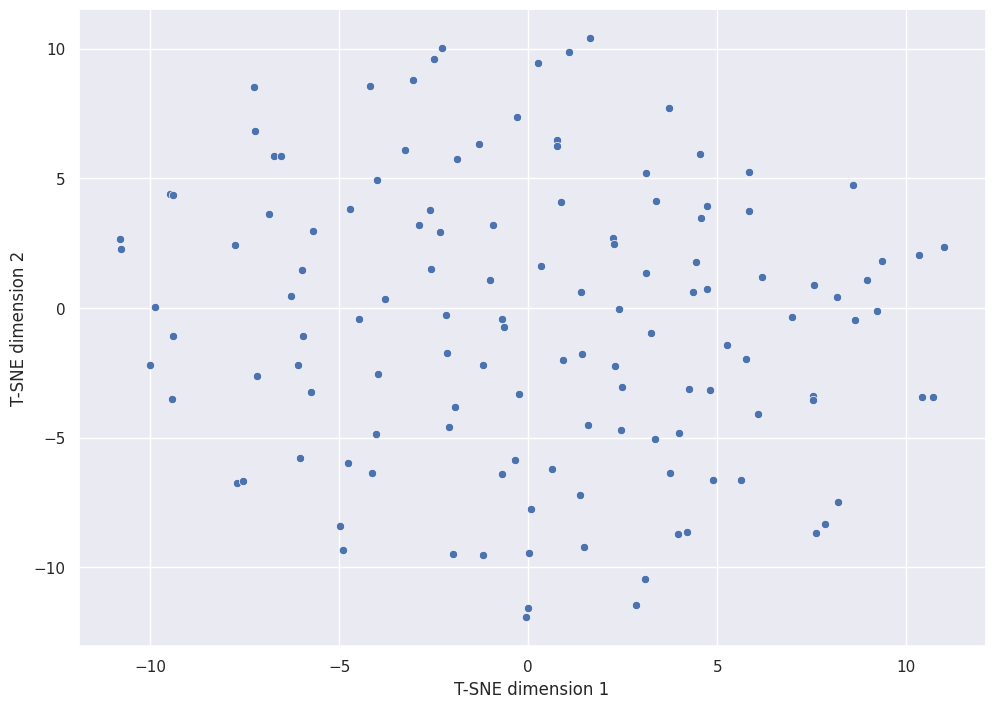

In [53]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 2)
tsne = TSNE(perplexity=30)
X_embedded = tsne.fit_transform(candidate_embeddings)

sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], legend='full')
plt.xlabel(xlabel='T-SNE dimension 1')
plt.ylabel(ylabel='T-SNE dimension 2')
plt.show()